In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
#maxEvents = 10000
maxEvents = 200000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

superstrip_size = 16

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def delta_phi(lhs, rhs):  # in radians
  rad = lhs - rhs
  while rad <  -np.pi:  rad += np.pi*2
  while rad >= +np.pi:  rad -= np.pi*2
  return rad

def delta_theta(lhs, rhs):  # in radians
  rad = lhs - rhs
  return rad

def range_phi_deg(deg):
  while deg <  -180.:
    deg += 360.
  while deg >= +180.:
    deg -= 360.
  return deg

def calc_phi_loc_deg_from_glob(glob, sector):
  # glob in deg, sector [1-6]
  glob = range_phi_deg(glob)
  loc = glob - 15. - (60. * (sector-1))
  return loc

def calc_phi_loc_int(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  phi_int = int(round(loc))
  return phi_int

def calc_phi_loc_int_1(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  #phi_int = int(round(loc))
  phi_int = loc  # no cast to int
  return phi_int

def calc_theta_int(theta, endcap):
  # theta in deg, endcap [-1,+1]
  if endcap == -1:
    theta = 180. - theta
  theta = (theta - 8.5) * 128./(45.0-8.5)
  theta_int = int(round(theta))
  return theta_int

In [5]:
# Collect hits in ME1/1a, or ME1/1b, or ME1/2 from events 
# where the hits exist in the same sector, but different F/R.
# Calculate the difference in the integer phi unit and 
# the correction to the common plane use the bend.

class Collector(object):
  def __init__(self, select_fn):
    self.select_fn = select_fn
    self.select_fn_2 = lambda hit: hit.neighbor == 0 and hit.bx == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0
  
  def run(self, hits):
    cached_hits = []
    found_f = False
    found_r = False
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        if hit.fr == 1:
          found_f = True
        elif hit.fr == 0:
          found_r = True
        else:
          raise Exception('Expect only F or R')
        cached_hits.append(hit)
    
    found_same_sector = (len(set([hit.sector for hit in cached_hits])) == 1)
    
    if found_f and found_r and found_same_sector:
      if len(cached_hits) != 2:
        #raise Exception('Expect only 2 hits')
        pass
      else:
        hit_f = None
        hit_r = None
        for ihit, hit in enumerate(cached_hits):
          hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
          hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
          if abs(int(hit.fph) - hit.emtf_phi) > 5:
            s = '{0}, {1}'.format(int(hit.fph), hit.emtf_phi)
            raise Exception('Expect at most +/-5 correction, but: ' + s)

          if hit.fr == 1:
            hit_f = hit
          elif hit.fr == 0:
            hit_r = hit
          else:
            raise Exception('Expect only F or R')

        assert(hit_f is not None)
        assert(hit_r is not None)
        if abs(hit_r.chamber - hit_f.chamber) != 1 and abs(hit_r.chamber - hit_f.chamber) != (36-1):
          s = '{0}, {1}'.format(hit_r.chamber, hit_f.chamber)
          raise Exception('Expect chamber differ by 1, but: ' + s)

        return (0.5*(hit_r.fph - hit_f.fph), (hit_r.bend * hit_r.endcap), (hit_f.bend * hit_f.endcap))
    return (np.inf, np.inf, np.inf)

In [6]:
class GEMFinder(object):
  def __init__(self, select_fn, select_fn_gem):
    self.select_fn = select_fn
    self.select_fn_2 = lambda hit: hit.neighbor == 0 and hit.bx == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0
    self.select_fn_gem = select_fn_gem
    
  def run(self, hits):
    cached_hits = []
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        cached_hits.append(hit)
    
    cached_hits_gem = []
    for ihit, hit in enumerate(hits):
      if self.select_fn_gem(hit) and self.select_fn_2(hit):
        cached_hits_gem.append(hit)
    
    hit_csc = None
    if cached_hits:
      hit_phis = [hit.emtf_phi for hit in cached_hits]
      if np.max(hit_phis) - np.min(hit_phis) < 8*3:
        hit_csc = np.random.choice(cached_hits)
    
    hit_gem = None
    if cached_hits_gem:
      hit_phis = [hit.emtf_phi for hit in cached_hits_gem]
      if np.max(hit_phis) - np.min(hit_phis) < 8*3:
        hit_gem = np.random.choice(cached_hits_gem)
    return (hit_csc, hit_gem)

In [7]:
def process(verbose=1):
  tree = load_pgun()
  
  outs_me11a = []
  outs_me11b = []
  outs_me12 = []
  outs_gem_me11a = []
  outs_gem_me11b = []
  outs_gem_me12 = []
  
  select_fn_me11a = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 4)
  select_fn_me11b = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 1)
  select_fn_me12 = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 2)
  select_fn_ge11 = lambda hit: (hit.type == kGEM and hit.station == 1 and hit.ring == 1)
  
  collector_me11a = Collector(select_fn_me11a)
  collector_me11b = Collector(select_fn_me11b)
  collector_me12 = Collector(select_fn_me12)
  
  gemfinder_me11a = GEMFinder(select_fn_me11a, select_fn_ge11)
  gemfinder_me11b = GEMFinder(select_fn_me11b, select_fn_ge11)
  gemfinder_me12 = GEMFinder(select_fn_me12, select_fn_ge11)

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
      
    # Skip events with pT < 3 GeV
    if evt.particles[0].pt < 3:
      continue

    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    if verbose and ievt < 20:
      print("evt {0} has {1} particles and {2} hits".format(ievt, len(evt.particles), len(evt.hits)))
      for ihit, hit in enumerate(evt.hits):
        hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
        hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
        if abs(int(hit.fph) - hit.emtf_phi) > 5:
          s = '{0}, {1}'.format(int(hit.fph), hit.emtf_phi)
          raise Exception('Expect at most +/-5 correction, but: ' + s)
        print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12} {13}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2, hit.emtf_phi, hit.fph))
    
    (rf, bend_r, bend_f) = collector_me11a.run(evt.hits)
    if np.isfinite(rf):
      outs_me11a.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me11b.run(evt.hits)
    if np.isfinite(rf):
      outs_me11b.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me12.run(evt.hits)
    if np.isfinite(rf):
      outs_me12.append((part.invpt, rf, bend_r, bend_f))
      
    (hit_csc, hit_gem) = gemfinder_me11a.run(evt.hits)
    if (hit_csc is not None) and (hit_gem is not None):
      outs_gem_me11a.append((part.invpt, hit_csc.emtf_phi, hit_csc.fr, hit_csc.bend, hit_gem.emtf_phi, hit_gem.fr, hit_gem.bend))
      
    (hit_csc, hit_gem) = gemfinder_me11b.run(evt.hits)
    if (hit_csc is not None) and (hit_gem is not None):
      outs_gem_me11b.append((part.invpt, hit_csc.emtf_phi, hit_csc.fr, hit_csc.bend, hit_gem.emtf_phi, hit_gem.fr, hit_gem.bend))
      
    (hit_csc, hit_gem) = gemfinder_me12.run(evt.hits)
    if (hit_csc is not None) and (hit_gem is not None):
      outs_gem_me12.append((part.invpt, hit_csc.emtf_phi, hit_csc.fr, hit_csc.bend, hit_gem.emtf_phi, hit_gem.fr, hit_gem.bend))

  return (np.asarray(outs_me11a), np.asarray(outs_me11b), np.asarray(outs_me12), 
          outs_gem_me11a, outs_gem_me11b, outs_gem_me12)

In [8]:
outs_me11a, outs_me11b, outs_me12, outs_gem_me11a, outs_gem_me11b, outs_gem_me12 = process()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
evt 4 has 1 particles and 9 hits
.. hit  0 0 1 1 2 4 0 -163.266098022 28.40467453 0 0 0 1425 1424.03411865
.. hit  1 0 1 1 2 4 0 -163.265975952 29.4308719635 0 0 -1 1425 1424.04144287
.. hit  2 0 2 1 2 4 0 -162.978622437 27.7948722839 -50 0 0 1440 1441.28265381
.. hit  3 0 1 2 2 4 0 -162.734024048 28.0849151611 0 0 0 1455 1455.95855713
.. hit  4 0 2 2 2 4 0 -162.661026001 27.230890274 -21 0 0 1460 1460.33843994
.. hit  5 0 1 3 2 4 1 -163.000335693 27.8482627869 0 0 0 1440 1439.9798584
.. hit  6 0 2 3 3 4 0 -163.285934448 28.7258625031 23 0 0 1424 1422.84393311
.. hit  7 0 1 4 2 4 1 -163.534225464 28.0116901398 0 0 0 1408 1407.94647217
.. hit  8 0 2 4 3 4 0 -163.910064697 29.5494651794 19 0 0 1384 1385.39611816
evt 5 has 1 particles and 9 hits
.. hit  0 0 3 1 1 3 1 171.668624878 19.8607978821 0 0 0 3520 3520.11749268
.. hit  1 0 3 1 1 3 1 171.721572876 19.8613014221 0 0 0 3523 3523.29437256
.. hit  2

Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processing event: 39000
Processing event: 40000
Processing event: 41000
Processing event: 42000
P

In [9]:
print outs_me11a.shape
print outs_me11b.shape
print outs_me12.shape

(411, 4)
(1390, 4)
(1150, 4)


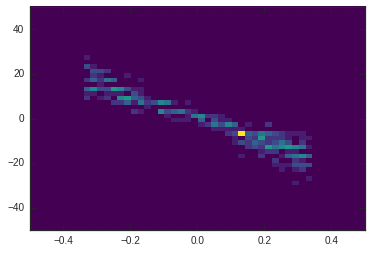

In [10]:
x = outs_me11a[:,0]
y = outs_me11a[:,1]

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-0.5,0.5),(-50,50)))
plt.show()

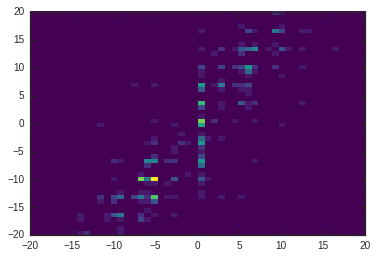

In [11]:
x = outs_me11a[:,2]
y = outs_me11a[:,1]

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

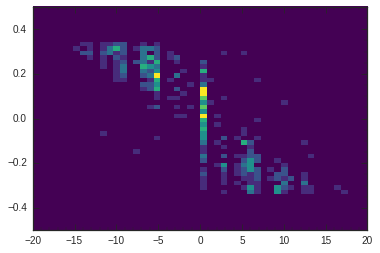

In [12]:
x = outs_me11a[:,2]
y = outs_me11a[:,0]

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

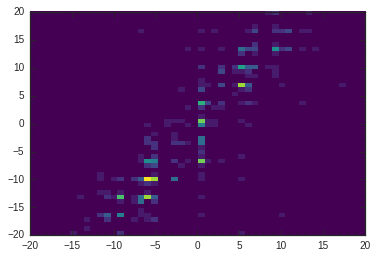

In [13]:
x = outs_me11a[:,3]
y = outs_me11a[:,1]

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

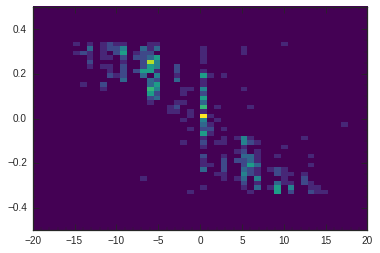

In [14]:
x = outs_me11a[:,3]
y = outs_me11a[:,0]

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
def doit():
  for x, y, label in xy:
    print label
    lin = LinearRegression(fit_intercept=False)
    lin.fit(np.atleast_2d(x).T, y)
    print lin.intercept_, lin.coef_
    rid1 = Ridge(fit_intercept=False,alpha=0.1)
    rid1.fit(np.atleast_2d(x).T, y)
    print rid1.intercept_, rid1.coef_
    rid2 = Ridge(fit_intercept=False,alpha=0.01)
    rid2.fit(np.atleast_2d(x).T, y)
    print rid2.intercept_, rid2.coef_

In [16]:
# ME1/1a
xy = [
  (outs_me11a[:,2], outs_me11a[:,1], 'x: bend_r, y: dist'),
  (outs_me11a[:,2], outs_me11a[:,0], 'x: bend_r, y: q/pt'),
  (outs_me11a[:,3], outs_me11a[:,1], 'x: bend_f, y: dist'),
  (outs_me11a[:,3], outs_me11a[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [1.53271712]
0.0 [1.53270886]
0.0 [1.53271629]
x: bend_r, y: q/pt
0.0 [-0.02745651]
0.0 [-0.02745637]
0.0 [-0.0274565]
x: bend_f, y: dist
0.0 [1.13457611]
0.0 [1.13457119]
0.0 [1.13457562]
x: bend_f, y: q/pt
0.0 [-0.02213332]
0.0 [-0.02213323]
0.0 [-0.02213331]


In [17]:
# ME1/1b
xy = [
  (outs_me11b[:,2], outs_me11b[:,1], 'x: bend_r, y: dist'),
  (outs_me11b[:,2], outs_me11b[:,0], 'x: bend_r, y: q/pt'),
  (outs_me11b[:,3], outs_me11b[:,1], 'x: bend_f, y: dist'),
  (outs_me11b[:,3], outs_me11b[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [1.35340815]
0.0 [1.35340767]
0.0 [1.3534081]
x: bend_r, y: q/pt
0.0 [-0.01427337]
0.0 [-0.01427336]
0.0 [-0.01427337]
x: bend_f, y: dist
0.0 [1.31110137]
0.0 [1.31110092]
0.0 [1.31110133]
x: bend_f, y: q/pt
0.0 [-0.0139334]
0.0 [-0.0139334]
0.0 [-0.0139334]


In [18]:
# ME1/2
xy = [
  (outs_me12[:,2], outs_me12[:,1], 'x: bend_r, y: dist'),
  (outs_me12[:,2], outs_me12[:,0], 'x: bend_r, y: q/pt'),
  (outs_me12[:,3], outs_me12[:,1], 'x: bend_f, y: dist'),
  (outs_me12[:,3], outs_me12[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [0.91154882]
0.0 [0.91154849]
0.0 [0.91154879]
x: bend_r, y: q/pt
0.0 [-0.01207898]
0.0 [-0.01207897]
0.0 [-0.01207898]
x: bend_f, y: dist
0.0 [0.82130125]
0.0 [0.82130101]
0.0 [0.82130122]
x: bend_f, y: q/pt
0.0 [-0.01096204]
0.0 [-0.01096203]
0.0 [-0.01096204]


In [19]:
data = [(x[0], x[1] - x[1+3]) for x in outs_gem_me11a]